## Lecture 16-17 Decision Trees and Random Forests

### Decision Trees

Example 1: Small dataset with numerical and categorical data

| id | Age | Smoker | FamilyHx | Disease (y) |
|---:|----:|:------:|:--------:|:-----------:|
| 1  | 30  |   no   |    no    |      0      |
| 2  | 37  |  yes   |    no    |      0      |
| 3  | 41  |   no   |   yes    |      0      |
| 4  | 46  |  yes   |    no    |      1      |
| 5  | 50  |   no   |   yes    |      1      |
| 6  | 52  |  yes   |   yes    |      1      |
| 7  | 58  |   no   |    no    |      0      |
| 8  | 63  |  yes   |    no    |      1      |

Let $X$ be training data set.

In [8]:
import pandas as pd
import numpy as np

# --- Raw dataset as a DataFrame ---
df = pd.DataFrame({
    "id":       [1, 2, 3, 4, 5, 6, 7, 8],
    "Age":      [30, 37, 41, 46, 50, 52, 58, 63],
    "Smoker":   ["no","yes","no","yes","no","yes","no","yes"],
    "FamilyHx": ["no","no","yes","no","yes","yes","no","no"],
    "Disease":  [0, 0, 0, 1, 1, 1, 0, 1],  # y
})

# Features & target
X = df[["Age", "Smoker", "FamilyHx"]]
y = df["Disease"].astype(int).values

#print(X)
#print(y)
df


,id,Age,Smoker,FamilyHx,Disease
0,1,30,no,no,0
1,2,37,yes,no,0
2,3,41,no,yes,0
3,4,46,yes,no,1
4,5,50,no,yes,1
5,6,52,yes,yes,1
6,7,58,no,no,0
7,8,63,yes,no,1


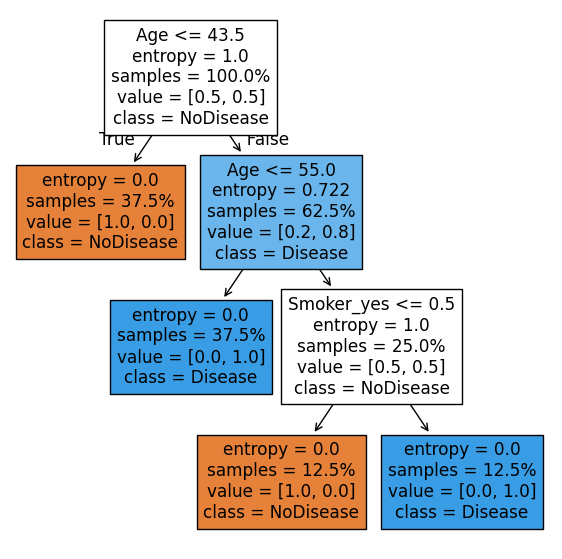

In [53]:
from sklearn import tree
import matplotlib.pyplot as plt

clf = tree.DecisionTreeClassifier(max_depth=3, criterion="entropy",
                                  splitter="best", random_state=411)

# This won't work with X as it is.   It doesn't like non-numeric
# data.  I need to convert yes and no to 1 and 0.
#clf.fit(X, y)

# get_dummies will convert categorical variables into a one-hot encoding
# like 	
#
#   Age	Smoker_no	Smoker_yes	FamilyHx_no	FamilyHx_yes
#   0	30	True	False	True	False
#   1	37	False	True	True	False
X = pd.get_dummies(df[["Age","Smoker","FamilyHx"]], drop_first=False)
y = df["Disease"].values

clf.fit(X, y)
plt.figure(figsize=(7, 7))
tree.plot_tree(clf,
               feature_names=X.columns,
               class_names=["NoDisease","Disease"],
               filled=True,
               proportion=True)

plt.show()



## Playing with ipywidgets

I've never built an interactive UI inside jupyter notebooks, so 
I thought I would give it a try.


In [28]:
# If you haven't already:
# pip install ipywidgets
# and enable in JupyterLab with:
# jupyter nbextension enable --py widgetsnbextension

from ipywidgets import Button, IntText, VBox, Label
from IPython.display import display

# Create widgets
button = Button(description="Click me!")
counter = IntText(value=0, description="Count:")
label = Label(value="Hello, world!")

# Define what happens when the button is clicked
def on_button_clicked(b):
    counter.value += 1
    label.value = f"You’ve clicked {counter.value} times!"

# Connect the callback
button.on_click(on_button_clicked)

# Display in the notebook
display(VBox([label, counter, button]))

## Bootstrapping


In [55]:
import numpy as np
import pandas as pd
from ipywidgets import Button, Output, VBox
from IPython.display import display

# Original dataset (just 8 numbers)
rng = np.random.default_rng()
data = rng.choice(np.arange(1, 21), size=8, replace=False)

out = Output()
button = Button(description="Draw Bootstrap Sample 🎲", button_style="info")

def draw_bootstrap(_):
    with out:
        out.clear_output(wait=True)
        sample = np.random.choice(data, size=len(data), replace=True)
        df = pd.DataFrame({
            "Original": data,
            "Sample": sample
        })
        print("Original Data:", data)
        print("Bootstrap Sample:", sample)
        display(df.style.set_properties(**{'text-align': 'center'}))

button.on_click(draw_bootstrap)
display(VBox([button, out]))

# Draw once initially
draw_bootstrap(None)

## Decision tree with high variance.


In [54]:

# If needed: pip install ipywidgets && jupyter nbextension enable --py widgetsnbextension
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import Button, HBox, VBox, ToggleButtons, Output
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample

# --- fixed small dataset (so resampling shows variance clearly) ---
rng = np.random.RandomState(0)
n = 80                       # number of samples
X = rng.normal(size=(n, 2))  # 2-d Gaussian N(0,1) with n samples. n x 2 matrix.
w = np.array([1.0, 0.8])     # array of 64-bit floating points.
b = 0.2

# think of w^T as transposing the w array into a column vector.
# X @ w essentially performs the linear algebra $(X w^T)^T$.
# The outer tranpose turns the n x 1 column vector 
# resulting from $X w^T$ into a 1 x n row vector.  The 1 x n row
# vector is just a numpy array of n values.
#
# X @ w causes y to increase with either x1 or x2.  In fact
# y = (1 * x1 + 0.8 * x2 - 0.2 + noise) > 0
y = (X @ w - b + rng.normal(scale=0.6, size=n) > 0).astype(int)

# grid for filling in the class colors in the background
# X[:,0] means "all rows, column 0"
# X[:,0].min() means "minimum value of column 0"
# We subtract one from the minimum so the class coloring
# extends some amount beyond the minimum x1 value.
# X[:,0].max()+1.0 says "extend the class coloring 
# distance 1.0 beyond the maximum x1 value."
x1_min, x1_max = X[:,0].min()-1.0, X[:,0].max()+1.0
x2_min, x2_max = X[:,1].min()-1.0, X[:,1].max()+1.0

# create a 300x300 grid of points covering the feature space
# that spans between (x1_min, x1_max) and (x2_min, x2_max).
xx1, xx2 = np.meshgrid(np.linspace(x1_min,x1_max,300),
                       np.linspace(x2_min,x2_max,300))

# ravel
grid = np.c_[xx1.ravel(), xx2.ravel()]

# UI
mode = ToggleButtons(options=["Single Tree", "Random Forest"], 
                     value="Single Tree")
btn = Button(description="Resample & Redraw", button_style="")
out = Output()

def draw(_=None):
    with out:
        out.clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(5.5, 5))
        # resample (bootstrap) the same underlying dataset to show instability
        Xb, yb = resample(X, y, replace=True, 
                          random_state=rng.randint(0, 1_000_000))
        if mode.value == "Single Tree":
            model = DecisionTreeClassifier(criterion="entropy", 
                                           random_state=rng.randint(0,1_000_000))
        else:

            # n_estimators: number of trees in the forest
            # max_features: when set to sqrt it considers sqrt(n_features).
            # There are exactly 2 features here, so sqrt(2) ~= 1.414 which
            # truncates to 1 feature considered at each split.  Thus
            # the random forest randomly picks either x1 or x2 at each split.
            # bootstrap=True means each decision tree is trained by
            # selecting n=80 samples at random with replacement from
            # the original n=80 samples.
            # random_state: we seed it randomly so that every redraw is different.
            model = RandomForestClassifier(n_estimators=200, 
                                           max_features="sqrt",
                                           bootstrap=True,
                                           random_state=rng.randint(0,1_000_000))
        model.fit(Xb, yb)
        Z = model.predict_proba(grid)[:,1].reshape(xx1.shape)

        # decision surface + 0.5 contour
        ax.contourf(xx1, xx2, Z, levels=25, alpha=0.7)
        ax.contour(xx1, xx2, Z, levels=[0.5], linewidths=2.0)

        # data (same color mapping in each redraw)
        ax.scatter(X[y==0,0], X[y==0,1], s=14, alpha=0.8, label="Class 0")
        ax.scatter(X[y==1,0], X[y==1,1], s=14, alpha=0.8, label="Class 1")
        ax.set_xlabel("x1"); ax.set_ylabel("x2")
        ax.set_title(f"{mode.value}: new boundary from a new sample")
        ax.legend(loc="upper left")
        plt.tight_layout()
        plt.show()

btn.on_click(draw)
display(VBox([HBox([mode, btn]), out]))
draw()  # initial render

In [46]:
X = rng.normal(size=(4, 2))  # 2-d Gaussian N(0,1) with n samples. n x 2 matrix.
w = np.array([1.0, 0.8])

print(X)
print(X[0][0]*w[0] + X[0][1]*w[1])
X @ w

[[-0.13105401  1.13307988]
 [-1.9518041  -0.65989173]
 [-1.13980246  0.78495752]
 [-0.55430963 -0.47063766]]
0.7754098921063652


array([ 0.77540989, -2.47971749, -0.51183644, -0.93081975])